## The Problem

Bellhops is a startup moving company that contracts movers and truck drivers to provide a high-quality, on-demand moving experience.  One of the company's logistical challenges is figuring out how long a move should be scheduled for. Because drivers are paid a higher hourly rate than movers, stacking several shorter moves with more movers is more economical than scheduling longer moves with more drivers and fewer movers. In general, Bellhops would like to schedule moves so they are completed in under three hours. This would let Bellhops schedule a driver on two to three moves a day. However, roughly one-third of moves last longer than three hours. 

Currently the majority of moves are scheduled with two movers. Bellhops has found that for a given number of man hours worked, the average NPS score can increase by 20% and average poor experience discounts decrease by 50% when three movers are on a job instead of two. One action bellhops could take would be to schedule an extra bellhop on an order if it is predicted to go over the three hour mark.

If Bellhops could better predict whether or not a move was going to exceed the three-hour mark, Bellhops would be able to improve scheduling and thereby improve the customer experience.  

## Data

The data come from Bellhops’ internal data warehouse. For each move the company performs, it collects the following features:

Order Number - the internal id for the move

Market - the city in which the move took place

FS - whether or not the move was a "Full Service" move, a move for which bellhops provided a driver and a truck. These are almost always multi-location moves. Non-full service moves are "Labor Only," moves where bellhops only provides labor. Labor only moves can be single or multication.

Move Type - the type of move

Move Length Hours - the time between reservation start and the last clock out

Phone - dummy variable that equals one when the move was booked on the phone and zero when booked online

Executed Man Hours - the number of man hours it took to complete the move

Booked Man Hours - the number of man hours that were booked

Order Total Spots - the number of movers that worked on the order

House - whether or not the property type was a house

Residence - whether or not the property was a residence

Rooms - the number of rooms on the property

Coupon Amount - the value of the customer's coupon, if present

GRPN - whether or not the move was from Groupon

Num Effort Hops - the number of hops that had previousely received poor effort ratings from customers

Some Inventory - whether or not he customer provided us with any inventory during the booking process

"Beds" through "Boxes" - the number of the named items the customer reported

Reservation Start - the datetime at which the reservation was scheduled to start

Booked At - the date time at which the order was booked

Dense - whether or not the order occurred in a market with more that 10k people per sq. mile

Flights of Stairs - the total number of flights of stairs for all properties on the move

Large/Medium/Small Items - the number of "large"/"medium"/"small" items reported during the booking process

Stops - the number of locations on the move

Elevators - the number of elevators reported during the booking porcess

Additional Instructions - whether or not the customer reported additional instructions during the booking process

NPS - net promoter score

Num Bad Star Hops - the number of hops on the job with previous low overall reviews

Avg Prev Late Rate - the average of the movers' rates of being late on previous moves

Sum Prev Late Rate - the sum of the movers' rates of being late on previous moves

Max Late Clock In Hours - the latest any mover was to the move in hours

Sum Late Clock In Hours - the total number of man hours that movers were late to the move

City Pop - the population of the market

Pop Density - the population density of the market

## Cleaning

#### Setting Up
First, I imported pandas so I could work with this data as a DataFrame and numpy for feature engineering. I read the csv into a pandas DataFrame, with column ‘order_id’ as the index. 

#### Removing Extraneous Rows and Filling Nulls
Furthermore, I dropped about 20 rows out of 8,000 where the ‘move_length_hours’ column was null or less than 0. (There is clearly an issue with the data if it says the start time was after the end time.) As the independent variable is based on this column, it made no sense to replace values.

I removed less than 10 rows that were for moves of a depricated move type called "loadingorunloading" that was a stand-in used when it was unkown whether the move was actually of type "loading" or "unloading." 

For single-location moves that were booked after we started collecting the drive distance/time between move locations, I replaced null values for drive distance/time with 0 minutes/miles. I aslo added a columns for drive hours between moves.


#### Feature Engineering
With this project, I am trying to predict whether or not a move will run over 3 hours. I generated a column to represent the independent variable called ‘over’ that gives a '1' if the move length was over 3 hours and a '0' if not.

I transformed the ‘booked_at’ and ‘reservation_start’ columns into datetimes. From the ‘reservation_start’ column, I added columns that represent the hour of day the move began, whether or not that was in the morning, the day of week the move began, and whether or not that was a weekend day.

I added dummy variables for markets and move types.

Finally, I wrote the data to a csv, ready for exploratory data analysis.

In [386]:
import pandas as pd
import numpy as np

#Read csv into a pandas dataframe.
csv = 'move_length.csv'
df = pd.read_csv(csv, index_col = 'order_id')
df.head()

,market,move_type,fs,move_length_hours,executed_man_hours,booked_man_hours,order_total_spots,property_size_name,property_type_name,house,...,nps_promoter,nps_detractor,num_bad_star_hops,avg_prev_late_rate,sum_prev_late_rate,max_late_clock_in_hours,sum_late_clock_in_hours,phone,city_pop,pop_density
order_id,,,,,,,,,,,,,,,,,,,,,
482733,atlantaga,gopher,1,3.666667,7.50,8.0,2,1 Bedroom,Apartment/Condo,0,...,1.0,0.0,2,0.094274,0.282823,0.000000,0.000000,1,472522.0,5180.0
483964,atlantaga,atob,0,2.369167,5.25,4.0,2,Studio/Loft,Apartment/Condo,0,...,1.0,0.0,3,0.113870,0.341611,0.000000,0.000000,0,472522.0,5180.0
484309,atlantaga,gopher,1,5.066667,10.50,8.0,2,1 Bedroom,Apartment/Condo,0,...,NaN,NaN,3,0.122590,0.490359,0.000000,0.000000,0,472522.0,5180.0
484339,atlantaga,unloading,0,0.687500,2.00,4.0,2,1 Bedroom,Apartment/Condo,0,...,1.0,0.0,2,0.171529,0.343058,0.000000,0.000000,0,472522.0,5180.0
484509,atlantaga,gopher,1,2.565556,5.50,4.0,2,1 Bedroom,Apartment/Condo,0,...,NaN,NaN,5,0.113659,0.795613,0.016667,0.016667,0,472522.0,5180.0


In [387]:
#Drop rows where move_length_hours is null. 
#This is the column from which the independant variable is calculated. 
#It would not make sense to replace missing values and there is only a very small number of these.
df = df[df['move_length_hours'].notnull()]
df = df[df['move_length_hours'] > 0]

In [388]:
#Drop rows where move_type is 'loadingorunloading.' This is a depricated move type that shows up vary rarely in this dataset and would not help with predictions.
df = df[df['move_type'] != 'loadingorunloading']

In [389]:
#Fill in rows for single stop moves after drive distance/time existed with 0 minutes/miles
first_drive_record = np.min(df['reservation_start'][df['minutes_between_waypoints'].notnull()])

df['minutes_between_waypoints'] = np.where((df.reservation_start >= first_drive_record) & (df.stops == 1),0,df.minutes_between_waypoints)

df['hours_between_waypoints'] = df['minutes_between_waypoints']/60

df = df[df['hours_between_waypoints'] < 20]

df['miles_between_waypoints'] = np.where((df.reservation_start >= first_drive_record) & (df.stops == 1),0,df.miles_between_waypoints)

In [390]:
#Add a column for whether or not move exceeded 3 hours in length
df['over'] = np.where(df.move_length_hours > 3,1,0)

In [391]:
#Transform reservation_start and booked_at to datetimes
df['reservation_start'] = pd.to_datetime(df['reservation_start'])
df['booked_at'] = pd.to_datetime(df['booked_at'])

#Add a column for time of day
df['hour_of_day'] = df['reservation_start'].dt.hour

#Add a column for morning
df['morning'] = np.where(df['hour_of_day']<=12,1,0)

#Add a column for day of week (The day of the week with Monday=0, Sunday=6)
df['day_of_week'] = df['reservation_start'].dt.dayofweek

#Add a column for weekend
df['weekend'] = np.where(df['day_of_week']>=4 ,1,0)

#Transform day of week to category
df['day_of_week'] = df['reservation_start'].dt.dayofweek.astype('category')

#Add column for days between booking and reservation start
df['lead_days'] = (df['reservation_start'] - df['booked_at']).dt.days


In [392]:
#Adding dummy variables for markets and move_types (and removing the default value column)
df['mkt'] = df['market']
df['mt'] = df['move_type']
df = pd.get_dummies(df, columns=['mkt', 'mt'])
df = df.drop(['mkt_atlantaga','mt_unloading'], axis='columns')


In [393]:
df.to_csv('move_est.csv')

## Exploratory Data Analysis

Bellhops has known that move type impacts move length. It would also make sense that markets, number of stops, drive time between waypoints, and number of flights of stairs would impact move length. So I investigated those first in exploratory data analysis.

In [394]:
#Load libraries
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [395]:
#Read csv into a pandas dataframe.
csv = 'move_est.csv'
df = pd.read_csv(csv, index_col = 'order_id')
df.describe()

,fs,move_length_hours,executed_man_hours,booked_man_hours,order_total_spots,house,residence,rooms,coupon_amount,min_billable_man_hours,...,mkt_phoenixaz,mkt_pittsburghpa,mkt_raleighdurhamchapelhillnc,mkt_saintlouismo,mkt_washingtondcdc,mt_atob,mt_gopher,mt_inhouselabor,mt_loading,mt_packing
count,8262.000000,8262.000000,8262.000000,8262.000000,8262.000000,8262.000000,8262.000000,8262.000000,8262.000000,8262.000000,...,8262.000000,8262.000000,8262.000000,8262.000000,8262.000000,8262.000000,8262.000000,8262.000000,8262.000000,8262.000000
mean,0.523360,2.579733,6.394487,6.120673,2.224280,0.370855,0.922900,1.493101,34.996565,3.046720,...,0.004962,0.046720,0.101065,0.036069,0.037763,0.076979,0.523360,0.110264,0.146575,0.000121
std,0.499484,1.719362,5.221805,4.125178,0.567596,0.483063,0.266766,0.964514,86.163302,0.998968,...,0.070274,0.211051,0.301433,0.186473,0.190635,0.266574,0.499484,0.313237,0.353703,0.011002
min,0.000000,0.006944,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.321944,3.000000,4.000000,2.000000,0.000000,1.000000,1.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.262361,5.000000,6.000000,2.000000,0.000000,1.000000,1.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,3.424583,7.750000,8.000000,2.000000,1.000000,1.000000,2.000000,10.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,15.300000,79.750000,56.000000,7.000000,1.000000,1.000000,5.000000,2932.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


33 % of moves run over 3 hours.


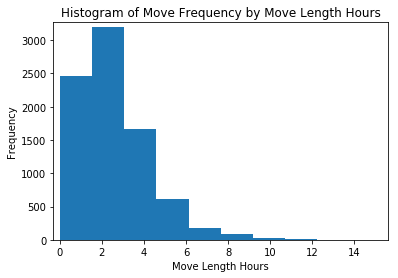

In [396]:
#Percent of moves over 3hr threshold
perc_over = round(np.mean(df.over)*100)
print(perc_over,"% of moves run over 3 hours.")

#Histogram of frequency of move lengths
plt.hist(df.move_length_hours)
plt.title('Histogram of Move Frequency by Move Length Hours')
plt.xlabel('Move Length Hours')
plt.ylabel('Frequency')
plt.margins(.02)
plt.show()

In [397]:
#Bellhops knows that full service moves tend to be longer than labor only moves, but by how much?
df['move_length_hours'].groupby(df['fs']).describe()

,count,mean,std,min,25%,50%,75%,max
fs,,,,,,,,
0,3938.0,1.650044,1.206029,0.006944,0.792083,1.381389,2.183542,12.074167
1,4324.0,3.426429,1.679314,0.236111,2.250000,3.083333,4.200000,15.300000


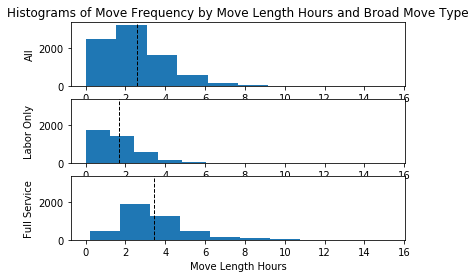

In [398]:
#What do move length distributions look like by broad move type?
ax1 = plt.subplot(3,1,1)
plt.hist(df.move_length_hours)
plt.axvline(df.move_length_hours.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Histograms of Move Frequency by Move Length Hours and Broad Move Type')
plt.ylabel('All')

plt.subplot(3,1,2,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.fs==0])
plt.axvline(df.move_length_hours[df.fs==0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Labor Only')

plt.subplot(3,1,3,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.fs==1])
plt.axvline(df.move_length_hours[df.fs==1].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Full Service')
plt.xlabel('Move Length Hours')

plt.show()

In [399]:
#How much more likely are full service moves to go over the threshold than labor only moves?
df['over'].groupby(df['fs']).mean()

fs
0    0.114017
1    0.520814
Name: over, dtype: float64

In [400]:
#How different are percent over 3 hours, mean move length hours, and mean executed man hours by move type?
df[['over','move_length_hours','executed_man_hours']].groupby(df['move_type']).mean().sort_values('over', ascending = False)

,over,move_length_hours,executed_man_hours
move_type,,,
gopher,0.520814,3.426429,8.527174
atob,0.300314,2.527970,5.777123
loading,0.123865,1.793630,4.335260
unloading,0.067854,1.482293,3.747668
inhouselabor,0.030735,1.062999,2.868277
packing,0.000000,1.981667,4.000000


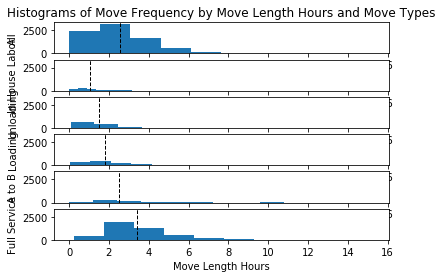

In [401]:
#What do move length distributions look like by move type?
ax1 = plt.subplot(6,1,1)
plt.hist(df.move_length_hours)
plt.axvline(df.move_length_hours.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Histograms of Move Frequency by Move Length Hours and Move Types')
plt.ylabel('All')

plt.subplot(6,1,2,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.move_type=='inhouselabor'])
plt.axvline(df.move_length_hours[df.move_type=='inhouselabor'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('In House Labor')

plt.subplot(6,1,3,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.move_type=='unloading'])
plt.axvline(df.move_length_hours[df.move_type=='unloading'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Unloading')

plt.subplot(6,1,4,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.move_type=='loading'])
plt.axvline(df.move_length_hours[df.move_type=='loading'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Loading')

plt.subplot(6,1,5,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.move_type=='atob'])
plt.axvline(df.move_length_hours[df.move_type=='atob'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('A to B')

plt.subplot(6,1,6,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.move_type=='gopher'])
plt.axvline(df.move_length_hours[df.move_type=='gopher'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('Full Service')

plt.xlabel('Move Length Hours')

plt.show()

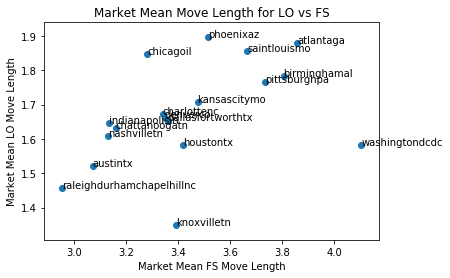

In [402]:
#Bellhops has a hunch that there are persitent move length differences among markets. Here are mean move lengths by market and move type.
ml = pd.crosstab(df.market, df.fs, values=df.move_length_hours, aggfunc=np.mean)

ml = ml.sort_values(1,ascending=False)

#Removing any obviouse an outliers.
mla = ml[ml[0] < 4]

#Reseting the index for easier plotting
mla.reset_index(inplace=True)

#Scatter plot
plt.scatter(mla[1],mla[0])
plt.title('Market Mean Move Length for LO vs FS')
plt.xlabel('Market Mean FS Move Length')
plt.ylabel('Market Mean LO Move Length')
for i, market in enumerate(mla.market):
    plt.annotate(mla.market[i], (mla[1][i],mla[0][i]))
plt.show()

In [403]:
df.market.unique()

array(['atlantaga', 'austintx', 'birminghamal', 'charlottenc',
       'chattanoogatn', 'chicagoil', 'dallasfortworthtx', 'denverco',
       'houstontx', 'indianapolisin', 'kansascitymo', 'knoxvilletn',
       'nashvilletn', 'phoenixaz', 'pittsburghpa',
       'raleighdurhamchapelhillnc', 'saintlouismo', 'washingtondcdc'],
      dtype=object)

It is interesting to see that move lengths of different move types are correlated for markets. This seems to suggest there are market specific differences that aren't just due to markets having different distributions of move types.

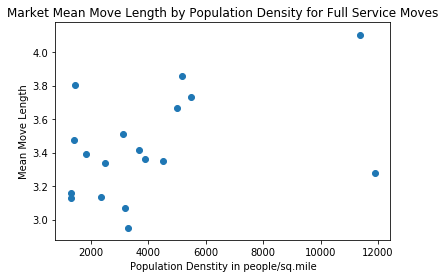

In [404]:
#Are these market specific differences driven by population density?
pop = pd.DataFrame(df['pop_density'].groupby(df['market']).mean())
ml_pop = ml.join(pop)

plt.scatter(ml_pop.pop_density,ml_pop[1])
plt.title('Market Mean Move Length by Population Density for Full Service Moves')
plt.xlabel('Population Denstity in people/sq.mile')
plt.ylabel('Mean Move Length')
plt.show()


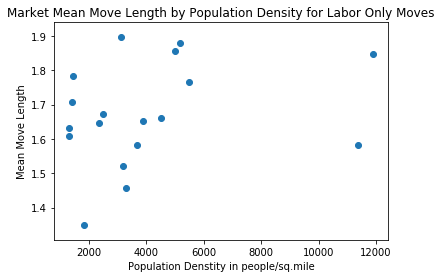

In [405]:
plt.scatter(ml_pop.pop_density,[ml_pop[0]])
plt.title('Market Mean Move Length by Population Density for Labor Only Moves')
plt.xlabel('Population Denstity in people/sq.mile')
plt.ylabel('Mean Move Length')
plt.show()


There isn't a plethora of observations, but the labor only scatter plot does suggest a positve correlation between mean move length and population density.

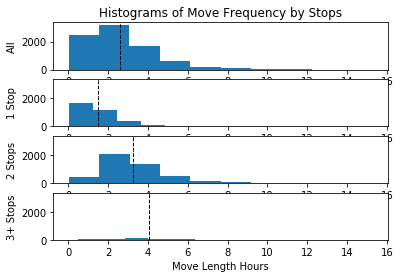

In [406]:
#We think that moves take longer the more stops there are
ax1 = plt.subplot(4,1,1)
plt.hist(df.move_length_hours)
plt.axvline(df.move_length_hours.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Histograms of Move Frequency by Stops')
plt.ylabel('All')

plt.subplot(4,1,2,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.stops==1])
plt.axvline(df.move_length_hours[df.stops==1].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('1 Stop')

plt.subplot(4,1,3,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.stops==2])
plt.axvline(df.move_length_hours[df.stops==2].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('2 Stops')

plt.subplot(4,1,4,sharex=ax1,sharey=ax1)
plt.hist(df.move_length_hours[df.stops>=3])
plt.axvline(df.move_length_hours[df.stops>=3].mean(), color='k', linestyle='dashed', linewidth=1)
plt.ylabel('3+ Stops')

plt.xlabel('Move Length Hours')
plt.show()

The top three histograms look very similar to the move type histograms. It is interesting to see this 3+ stop difference, although sample size for that group is small.

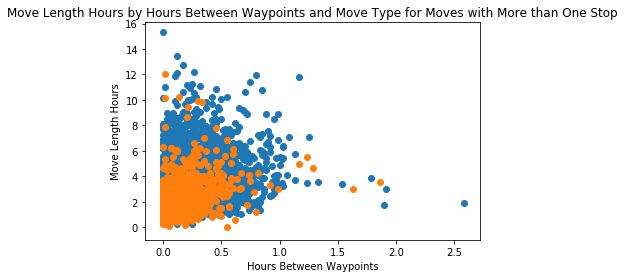

In [407]:
#You would think that drive time between waypoints would directly add to the move length
plt.scatter(df['hours_between_waypoints'][(df['fs']==1) & (df['stops']>1)],df['move_length_hours'][(df['fs']==1) & (df['stops']>1)])
plt.scatter(df['hours_between_waypoints'][(df['fs']==0) & (df['stops']>1)],df['move_length_hours'][(df['fs']==0) & (df['stops']>1)])
plt.title('Move Length Hours by Hours Between Waypoints and Move Type for Moves with More than One Stop')
plt.ylabel('Move Length Hours')
plt.xlabel('Hours Between Waypoints')
plt.show()

The relationship isn't extremely clear here. Variance/noise caused by other factor swamps the impact visually.

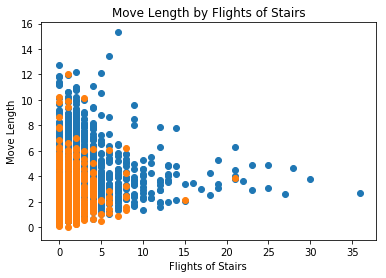

In [408]:
#Scatter for flights of stairs
plt.scatter(df['flights_of_stairs'][(df['fs']==1) & (df['stops']>1)],df['move_length_hours'][(df['fs']==1) & (df['stops']>1)])
plt.scatter(df['flights_of_stairs'][(df['fs']==0) & (df['stops']>1)],df['move_length_hours'][(df['fs']==0) & (df['stops']>1)])
plt.title('Move Length by Flights of Stairs')
plt.xlabel('Flights of Stairs')
plt.ylabel('Move Length')
plt.show()

### Additional Feature Engineering

In [428]:
#Add a column for correct booked man hours
df['even_base'] = np.where(np.floor(df['executed_man_hours'])%2==0,1,0)
df['small_mins'] = np.where(df['executed_man_hours'] - np.floor(df['executed_man_hours'])<= .5, 1, 0)
df['correct_booked_man_hours'] = np.where((df['even_base']==1) & (df['small_mins'] == 1), np.floor(df['executed_man_hours']/2)*2,np.ceil(df['executed_man_hours']/2)*2 )

#Adding columns that are combinations of columns
df['second_stop'] = np.where(df['stops'] >=2,1,0)
df['extra_stop'] = np.where(((df['fs']==1)|(df['move_type']=='atob')), df.stops-2, df.stops-1)
df['extra_hop'] = np.where(df['order_total_spots'] >2,df['order_total_spots'] - 2,0)
df['web_extra_hop'] = np.where((df['order_total_spots'] >2) & (df['phone'] == 1),df['order_total_spots'] - 2,0)
df['extra_rooms'] = np.where(df['rooms'] > 1,df['rooms']-1,0)
df['vd'] = np.where(df['pop_density']>5000,1,0)
df['pop_density'] = df['pop_density']/4000
df['coupon'] = np.where(df['coupon_amount'] > 0,1,0)
df['rooms_stops'] = df.rooms*df.stops

#Adding interaction columns
df['fs_dense'] = df['fs']*df['dense']
df['fs_rooms'] = df['fs']*df['rooms']
df['dense_apt'] = np.where((df['property_type_name']=='Apartment/Condo') & (df['dense']==1),1,0)

df['second_stop_extra_rooms'] = df['second_stop']*df['extra_rooms']
df['second_stop_dense'] = df['second_stop']*df['dense']
df['second_stop_extra_rooms_dense'] = df['second_stop']*df['extra_rooms']*df['dense']

df['vd_rooms'] = df['vd']*df['rooms']
df['house_rooms'] = df['house']*df['rooms']
df['rooms_stairs'] = df['rooms']*df['flights_of_stairs']
df['rooms_stairs_stops'] = df['rooms']*df['flights_of_stairs']* df['stops']
df['rooms_squared'] = df['rooms']*df['rooms']



In [436]:
#List of market dummies, leaving Atlanta out
market_dummies = ['mkt_austintx', 'mkt_birminghamal',
       'mkt_charlottenc', 'mkt_chattanoogatn', 'mkt_chicagoil',
       'mkt_dallasfortworthtx', 'mkt_denverco', 'mkt_houstontx',
       'mkt_indianapolisin', 'mkt_kansascitymo', 'mkt_knoxvilletn',
       'mkt_nashvilletn', 'mkt_phoenixaz', 'mkt_pittsburghpa',
       'mkt_raleighdurhamchapelhillnc', 'mkt_saintlouismo',
       'mkt_washingtondcdc']

#List of move type dummies, leaving unloading out
move_type_dummies = ['mt_atob', 'mt_gopher', 'mt_inhouselabor','mt_loading']

## Inferential Statistics

In this section, I evaluate the correlation between all features in the data set and the target variable and generate a pair plot of the ones that are most strongly correlated to the target variable. Then I generate a correlation matrix between the features to inspect which are most correlated with each other to highlight which ones I should potentially avoid including in a model together. Finally, I plug a couple combinations of features into models as a first pass at assessing explanatory power.

In [437]:
#Generate correlation matrix and take the absolute values
c = df.corr().abs()

#Take the colum that represent correlations with the independent variable and sort by  largest correlation
d = c.over.sort_values(ascending=False)

#Display all items in series
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(d)

over                             1.000000
move_length_hours                0.780753
executed_man_hours               0.634871
correct_booked_man_hours         0.632433
booked_man_hours                 0.481314
fs_rooms                         0.456598
second_stop                      0.433580
min_billable_man_hours           0.433131
mt_gopher                        0.433131
fs                               0.433131
stops                            0.405038
rooms_stops                      0.396974
minutes_between_waypoints        0.386428
hours_between_waypoints          0.386428
second_stop_extra_rooms          0.350958
miles_between_waypoints          0.326931
nps_score                        0.317653
nps_detractor                    0.296374
nps_promoter                     0.296233
rooms_stairs_stops               0.273008
extra_hop                        0.262734
order_total_spots                0.261052
max_late_clock_in_hours          0.240775
rooms_stairs                     0

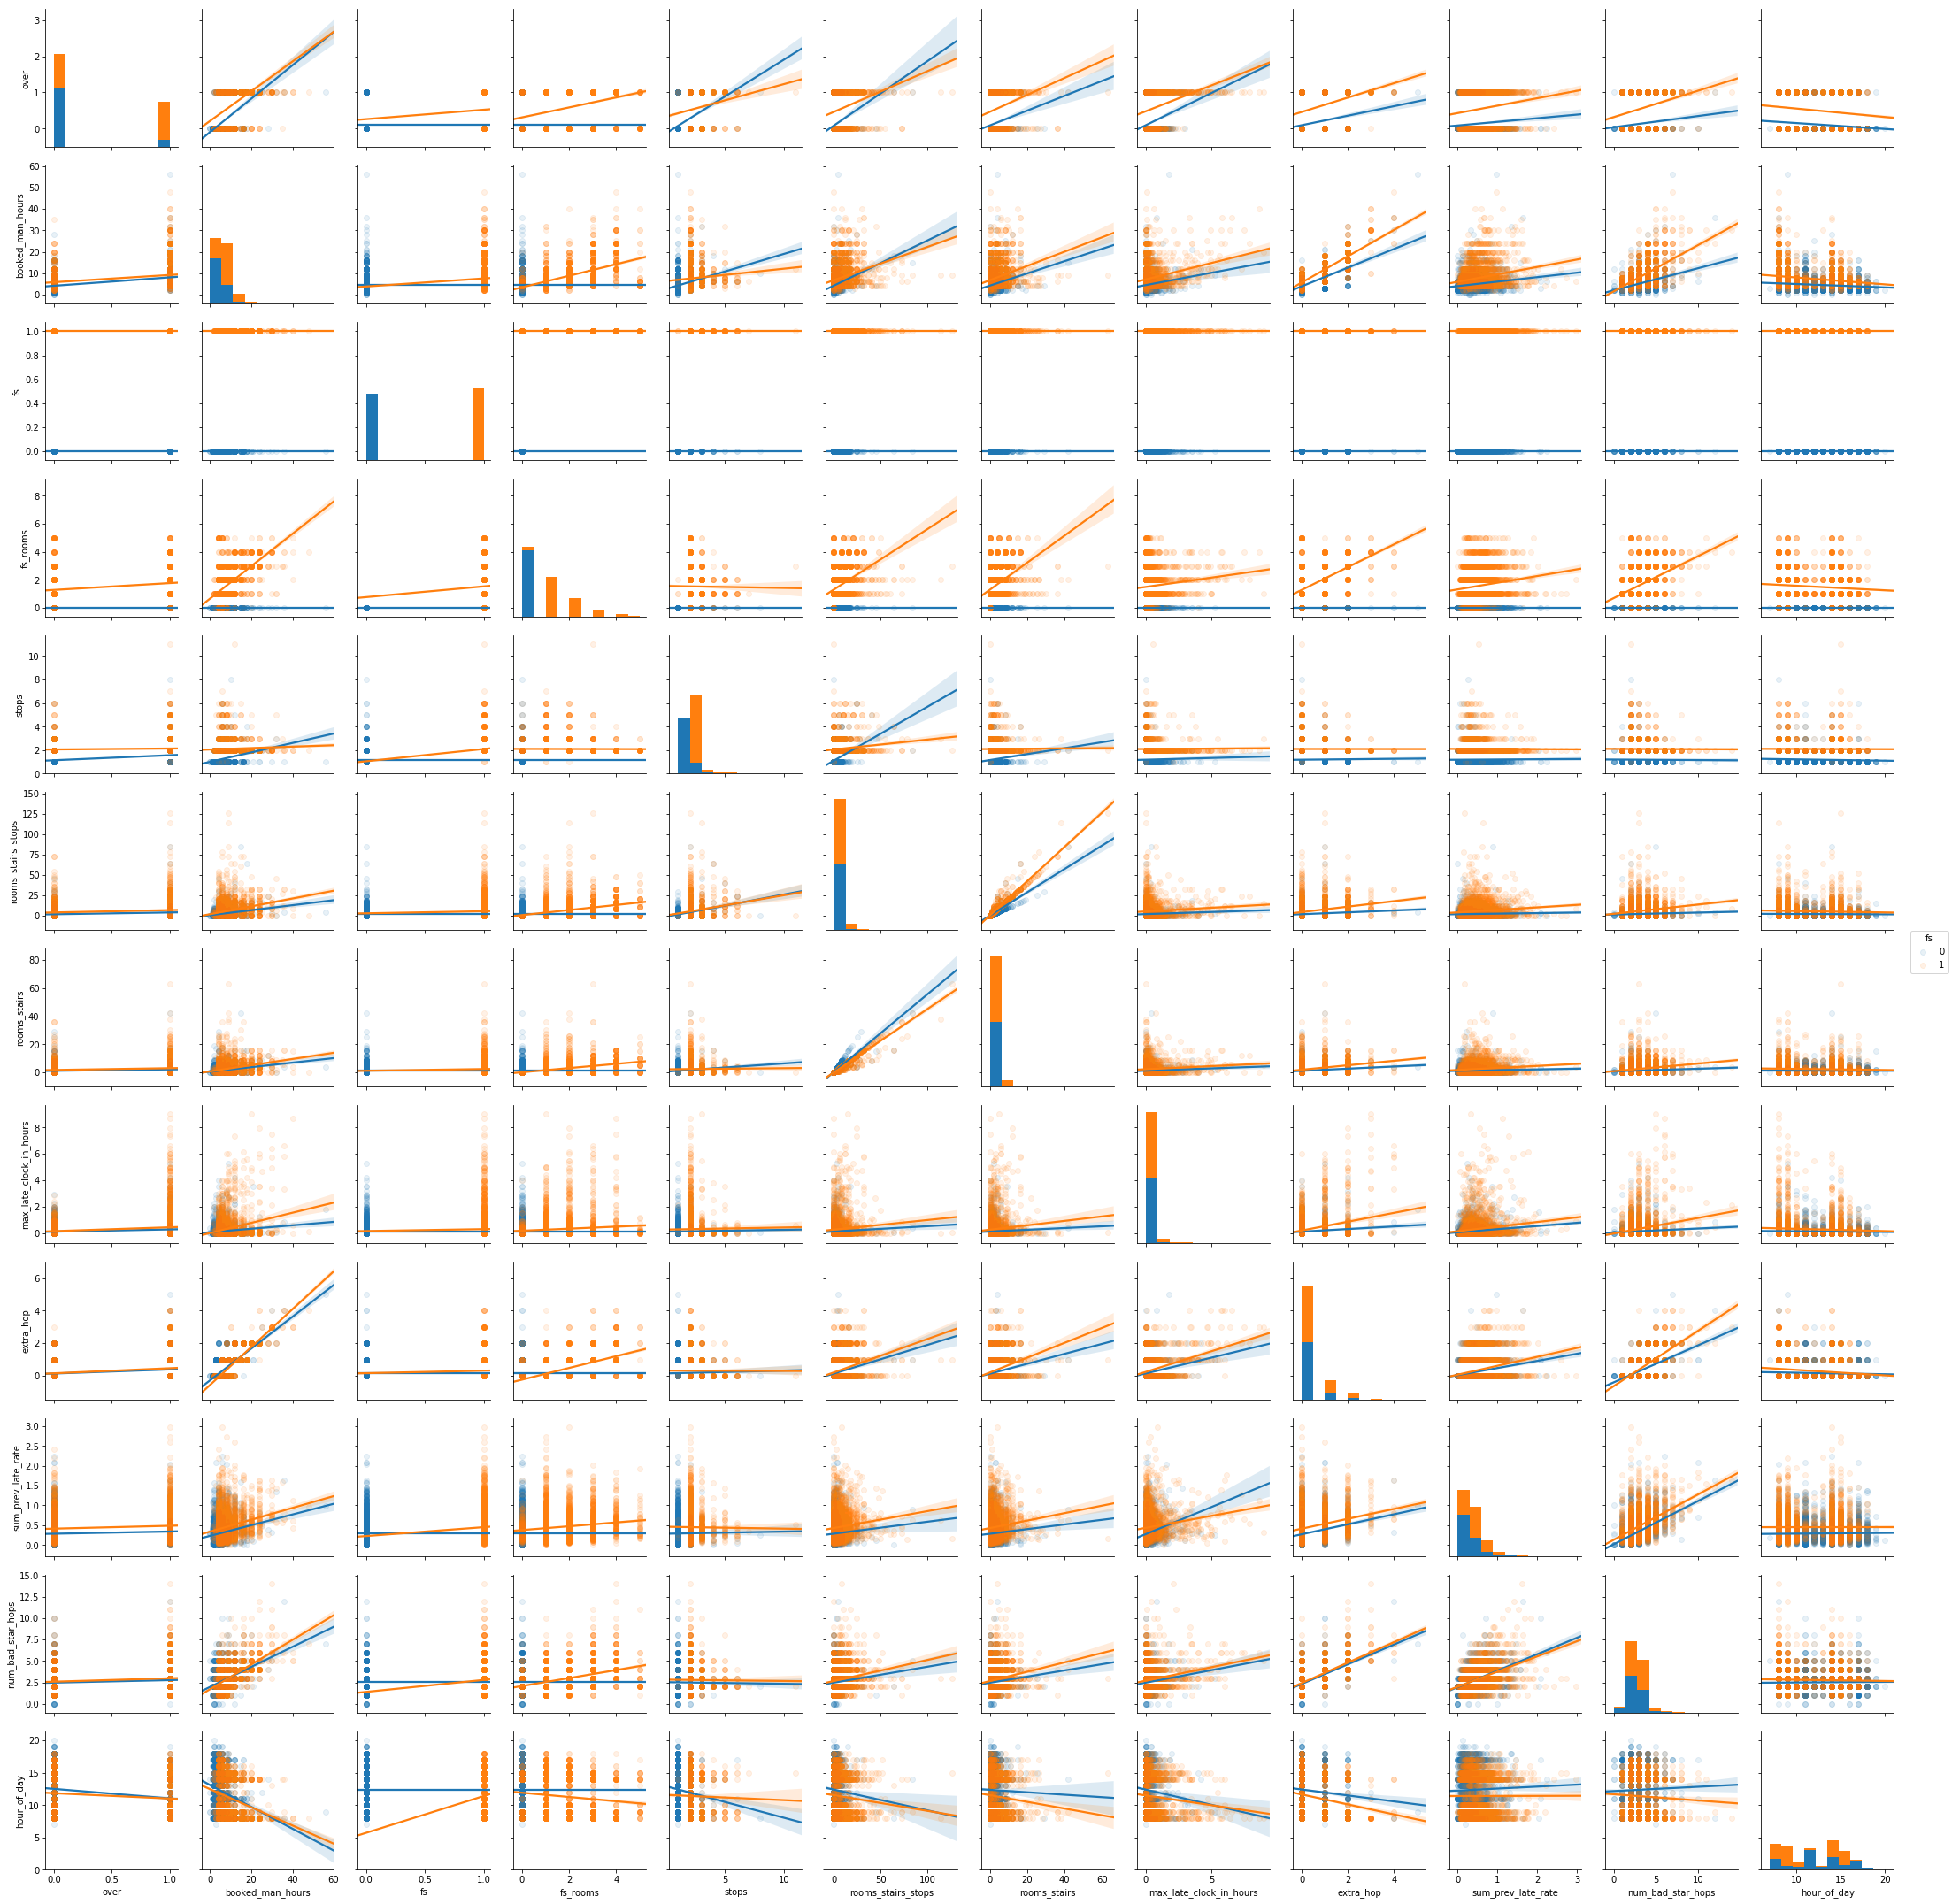

In [438]:
#Select the target variable and features that are most highly correlated with the target variable
pair_vars = ['over', 'booked_man_hours','fs','fs_rooms','stops','rooms_stairs_stops','rooms_stairs','max_late_clock_in_hours','extra_hop','sum_prev_late_rate','num_bad_star_hops','hour_of_day']
sns.pairplot(df, vars= pair_vars, hue='fs',kind="reg", plot_kws={'scatter_kws': {'alpha': 0.1}})


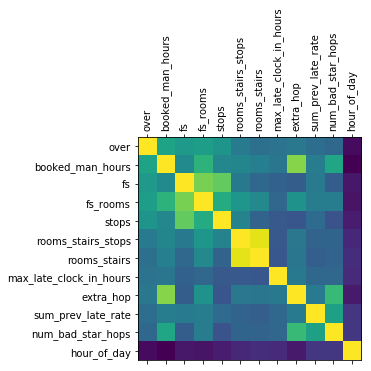

In [439]:
#Plotting correlation matrix to easily visualize which of the most highly correlated features are highly correlated with each other

#Generate and show a correlation matrix
df_corr = df[pair_vars]
plt.matshow(df_corr.corr())
 
#Add x labels
x_pos = np.arange(len(pair_vars))
plt.xticks(x_pos,pair_vars, rotation=90)

#Add y labels
y_pos = np.arange(len(pair_vars))
plt.yticks(y_pos,pair_vars)

#Show
plt.show()

In [440]:
import statsmodels.formula.api as smf
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

df_log = df[(df.hours_between_waypoints.notnull())]
x_cols = ['booked_man_hours','fs_rooms','hours_between_waypoints','residence','sum_prev_late_rate','num_bad_star_hops','hour_of_day','coupon']+ market_dummies + move_type_dummies

X = df_log[x_cols]
y = df_log['over']

import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.433918
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   over   No. Observations:                 8262
Model:                          Logit   Df Residuals:                     8233
Method:                           MLE   Df Model:                           28
Date:                Mon, 28 May 2018   Pseudo R-squ.:                  0.3134
Time:                        20:33:21   Log-Likelihood:                -3585.0
converged:                       True   LL-Null:                       -5221.4
                                        LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
booked_man_hours                  0.2955      0.013     23.033      0.000       0.270       0.321
fs_rooms                          0.2555      0.046      5.557      0.000       0.165       0.346
hours_between_waypoints           1.2425      0.180      6.898      0.000       0.889       1.596
residence                        -0.4138      0.097     -4.280      0.000      -0.603      -0.224
sum_prev_late_rate                0.0884      0.131      0.677      0.498      -0.168       0.344
num_bad_star_hops                -0.2902      0.035     -8.196      0.000      -0.360      -0.221
hour_of_day                      -0.1348      0.008    -16.021      0.000      -0.151      -0.118
coupon                            0.1908      0.065      2.945      0.003       0.064       0.318
mkt_austintx                     -0.9497      0.140     -6.772      0.000      -1.225      -0.675
mkt_birminghamal                 -0.6679      0.161     -4.139      0.000      -0.984      -0.352
mkt_charlottenc                  -0.9841      0.142     -6.935      0.000      -1.262      -0.706
mkt_chattanoogatn                -1.3389      0.123    -10.913      0.000      -1.579      -1.098
mkt_chicagoil                    -0.4584      0.201     -2.283      0.022      -0.852      -0.065
mkt_dallasfortworthtx            -0.5673      0.132     -4.287      0.000      -0.827      -0.308
mkt_denverco                     -0.7680      0.161     -4.772      0.000      -1.083      -0.453
mkt_houstontx                    -0.7445      0.188     -3.958      0.000      -1.113      -0.376
mkt_indianapolisin               -0.9181      0.172     -5.350      0.000      -1.254      -0.582
mkt_kansascitymo                 -0.6245      0.162     -3.855      0.000      -0.942      -0.307
mkt_knoxvilletn                  -1.0087      0.190     -5.321      0.000      -1.380      -0.637
mkt_nashvilletn                  -1.0048      0.121     -8.307      0.000      -1.242      -0.768
mkt_phoenixaz                    -0.8978      0.400     -2.244      0.025      -1.682      -0.114
mkt_pittsburghpa                 -0.4216      0.142     -2.964      0.003      -0.700      -0.143
mkt_raleighdurhamchapelhillnc    -1.2414      0.123    -10.101      0.000      -1.482      -1.000
mkt_saintlouismo                 -0.3321      0.163     -2.032      0.042      -0.652      -0.012
mkt_washingtondcdc               -0.0275      0.156     -0.175      0.861      -0.334       0.279
mt_atob                           0.3672      0.135      2.723      0.006       0.103       0.632
mt_gopher                         0.6300      0.122      5.161      0.000       0.391       0.869
mt_inhouselabor                  -1.2940      0.214     -6.054      0.000      -1.713      -0.875
mt_loading                       -0.2097      0.126     -1.667      0.096      -0.456       0.037
=================================================================================================
"""

**Thoughts**

All features but sum_prev_late_rate, mkt_washingtondcdc, and mt_loading  are significant at the 5% level. However, unfortunately, the psuedo R squared value is pretty low.


In [442]:
df.to_csv('move_est_plus.csv')